# Exploratory Data Analysis

## PySpark Setup

In [1]:
!wget -q https://archive.apache.org/dist/spark/spark-3.2.0/spark-3.2.0-bin-hadoop2.7.tgz
!tar xf spark-3.2.0-bin-hadoop2.7.tgz

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop2.7"

!pip install -q findspark
!pip install pyspark

!git clone https://github.com/avivfaraj/DSCI632-Project.git

     |████████████████████████████████| 281.4 MB 28 kB/s 
     |████████████████████████████████| 198 kB 55.0 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=4cf2bcc2026af7efbc92d08626e86275b274f0ae43c4de5103c4938ed7468073
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark
Cloning into 'DSCI632-Project'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 15 (delta 2), reused 5 (delta 1), pack-reused 0
Unpacking objects: 100% (15/15), done.


## Read Dataset

In [3]:

from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

import pandas as pd

spark = SparkSession.builder.appName("EDA").master("local[*]").getOrCreate()

mySchema = StructType([ StructField("index", IntegerType(), True)\
                       ,StructField("title", StringType(), True)\
                       ,StructField("author", StringType(), True)\
                       ,StructField("text", StringType(), True)\
                       ,StructField("label", IntegerType(), True)])

path = "./DSCI632-Project/data/train.csv"
pandas_df = pd.read_csv(path, header = 0)

spark_df =spark.createDataFrame(pandas_df, schema = mySchema)
spark_df.show(10)

+-----+--------------------+--------------------+--------------------+-----+
|index|               title|              author|                text|label|
+-----+--------------------+--------------------+--------------------+-----+
|    0|House Dem Aide: W...|       Darrell Lucus|House Dem Aide: W...|    1|
|    1|FLYNN: Hillary Cl...|     Daniel J. Flynn|Ever get the feel...|    0|
|    2|Why the Truth Mig...|  Consortiumnews.com|Why the Truth Mig...|    1|
|    3|15 Civilians Kill...|     Jessica Purkiss|Videos 15 Civilia...|    1|
|    4|Iranian woman jai...|      Howard Portnoy|Print \nAn Irania...|    1|
|    5|Jackie Mason: Hol...|     Daniel Nussbaum|In these trying t...|    0|
|    6|Life: Life Of Lux...|                 NaN|Ever wonder how B...|    1|
|    7|Benoît Hamon Wins...|     Alissa J. Rubin|PARIS  —   France...|    0|
|    8|Excerpts From a D...|                 NaN|Donald J. Trump i...|    0|
|    9|A Back-Channel Pl...|Megan Twohey and ...|A week before Mic...|    0|

## Distinct Authors

In [4]:
# Distinct Authors
(spark_df
    .filter(spark_df["author"] != "NaN")    # Remove NaN values (missing values)
    .select("author")                       # Select author attribute
    .rdd                                    # Conver to RDD
    .map(lambda x: x[0].lower())            # Convert to lower case letters
    .distinct()                             # Get unique author values
    .count()                                # Count distinct authors
)


4194

## Class Balance

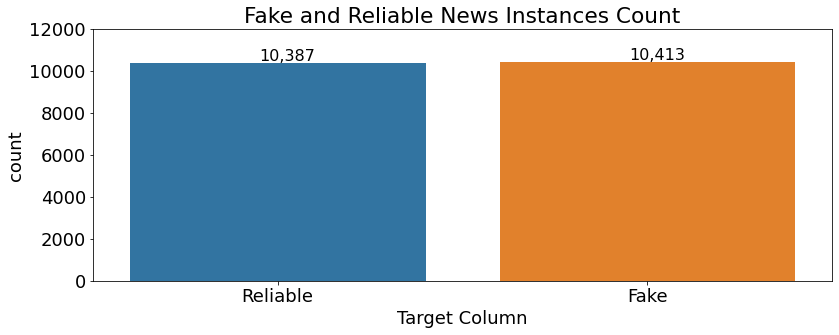

In [5]:
####################### Code Citation #######################
# Author: Rishikesh Kumar Rishi
# Date: 09 October 2021
# Title: Matplotlib – How to show the count values on the top of a bar in a countplot?
# URL: https://www.tutorialspoint.com/matplotlib-how-to-show-the-count-values-on-the-top-of-a-bar-in-a-countplot
#############################################################

import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df = pd.DataFrame(dict(col1=spark_df.select("label").rdd.map(lambda x: x[0]).collect()))

ax = sns.countplot(x="col1", data=df)
ax.set_ylim([0, 12000])
ax.set_xlabel("Target Column")
ax.set_title("Fake and Reliable News Instances Count")
ax.set_xticklabels(["Reliable", "Fake"])

for patch in ax.patches:
   ax.annotate('{:,d}'.format(patch.get_height()),                # Count
               (patch.get_x()+0.35, patch.get_height()+100),          # x,y coordinates for label.
               fontsize=16)   
   
plt.show()

## Text is missing

In [6]:
df_no_text = spark_df.filter(spark_df["text"] == "NaN")

print("Text is NaN: " + str(df_no_text.count()) + " Rows")
df_no_text.filter(df_no_text["author"] == "NaN").count()

Text is NaN: 39 Rows


39

In [7]:
df_no_text.filter(df_no_text["title"] == "NaN").count()

0

In [8]:
df_no_text.filter(df_no_text["label"] == 1).count() == df_no_text.count()

True

1. There are 39 rows missing text
1. All text missing rows are also missing the author!
2. All text missing rows are fake!

## Title is missing

In [9]:
df_no_title = spark_df.filter(spark_df["title"] == "NaN")


In [10]:
df_no_title.filter(df_no_title["author"] == "NaN").count() # 0
df_no_title.filter(df_no_title["text"] == "NaN").count() # 0

0

In [11]:
df_no_title.filter(df_no_title["label"] == 1).count() == df_no_title.count()

True

In [12]:
df_no_title.count()

558

1. There are 558 rows missing a title!
1. All rows missing title, do not also miss both author and text values
1. All rows missing title are fake!


## Author is missing

In [13]:
df_no_author = spark_df.filter(spark_df["author"] == "NaN")
df_no_author.count()

1957

In [14]:
df_no_author.filter(df_no_author["label"] == 1).count()

1931

In [15]:
df_no_author.filter(df_no_author["label"] == 0).count()

26

In [16]:
1957+558
(2515-26)/2515

0.989662027833002

1. There are 1957 rows missing an author!
1. Among these 1957 rows, 1931 are fake and 26 are reliable!
1. Overall missing values could indicate fake news since the majority of rows missing one or more values are also fake. In other words: 
There are 1957 rows missing an author and an additional 558 rows missing a title. The rows missing the text are included since they are all missing the author as well. Overall there are 2515 rows missing one or more feature. 26 of them are marked as reliable which means that 98.96% of all rows missing at least one feature are fake!

## Not missing at all

In [17]:
df_all_features = (spark_df
                    .filter(spark_df["author"] != "NaN")
                    .filter(spark_df["title"] != "NaN"))

df_all_features.count()

18285

In [18]:
df_all_features.filter(df_all_features["label"] == 0).count()

10361

In [19]:
from pyspark.sql.functions import col
df_all_features.filter(col("label") == 1).count()

7924

1. There are 18,285 rows that are not missing any feature
1. 10,361 out of these rows are reliable, whereas the other 7,924 are marked as fake!
